In [244]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [245]:
k = 0.0001
phi = 0.2
ksi = 0.0
cb = 0.15
lambd_nb = 1.8
mi_n = 0.2
lambd_bn = 0.1
y_n = 0.1
t_dom = (0, 10)
C_nmax = 0.55

size_t = int(((t_dom[1] - t_dom[0]) / (k)))

print(
    "Steps in time = {:d}\n".format(
        size_t,
    )
)

t = torch.arange(t_dom[0], t_dom[1], k, requires_grad=True).reshape(-1, 1)

Cl = np.loadtxt("Cn.csv", delimiter=",")
Cp = np.loadtxt("Cb.csv", delimiter=",")

numpy_input = np.array([Cl,Cp]).T


if torch.cuda.is_available():
    device = torch.device("cuda")
    t = t.to(device)
    data_input = torch.tensor(numpy_input,dtype=torch.float32).to(device)

    print(device)

Steps in time = 100000

cuda


In [246]:
model = nn.Sequential(
    nn.Linear(1, 16),
    nn.Tanh(),
    nn.Linear(16, 16),
    nn.Tanh(),
    nn.Linear(16, 16),
    nn.Tanh(),
    nn.Linear(16, 16),
    nn.Tanh(),
    nn.Linear(16, 2),
).to(device)

print(model)

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): Tanh()
  (6): Linear(in_features=16, out_features=16, bias=True)
  (7): Tanh()
  (8): Linear(in_features=16, out_features=2, bias=True)
)


In [247]:
def initial_condition(t):
    Cl = torch.zeros_like(t)
    Cp = torch.zeros_like(t) + 0.2
    return torch.cat([Cl, Cp], dim=1)

In [248]:
def pde(t, model):

    Cl, Cp = model(t).split(1, dim=1)

    # Calculando Cp

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cp_eq = (cb - lambd_nb * Cl) * Cp * phi - dCp_dt

    # Calculando Cl

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cl_eq = (y_n * Cp * (C_nmax - 1) - (lambd_bn * Cp + mi_n)) * Cl * phi - dCl_dt

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [249]:
loss_fn = nn.MSELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)
decay_rate = 0.99

lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer, gamma=decay_rate
)

n_epochs = 500
batch_size = 10000
C_pde_loss_it = torch.zeros(n_epochs).to(device)
C_data_loss_it = torch.zeros(n_epochs).to(device)
C_initial_loss_it = torch.zeros(n_epochs).to(device)
C_initial = initial_condition(t).to(device)

for epoch in range(n_epochs):
    for i in range(0, len(t), batch_size):

        t_initial = torch.zeros_like(t[i : i + batch_size])

        C_initial_pred = model(t_initial)

        loss_initial = loss_fn(C_initial[i : i + batch_size], C_initial_pred)

        C_pred = model(t[i : i + batch_size])

        loss_pde = loss_fn(C_pred, pde(t[i : i + batch_size], model))

        loss_data = loss_fn(C_pred, data_input[i : i + batch_size])

        loss = loss_initial + loss_pde + loss_data

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()

    C_pde_loss_it[epoch] = loss_pde.item()
    C_initial_loss_it[epoch] = loss_initial.item()
    C_data_loss_it[epoch] = loss_data.item()

    if epoch % 100 == 0:
        print(f"Finished epoch {epoch}, latest loss {loss}")

Finished epoch 0, latest loss 0.05388699471950531
Finished epoch 100, latest loss 0.04797574505209923
Finished epoch 200, latest loss 0.04791916534304619
Finished epoch 300, latest loss 0.047858826816082
Finished epoch 400, latest loss 0.04779427498579025


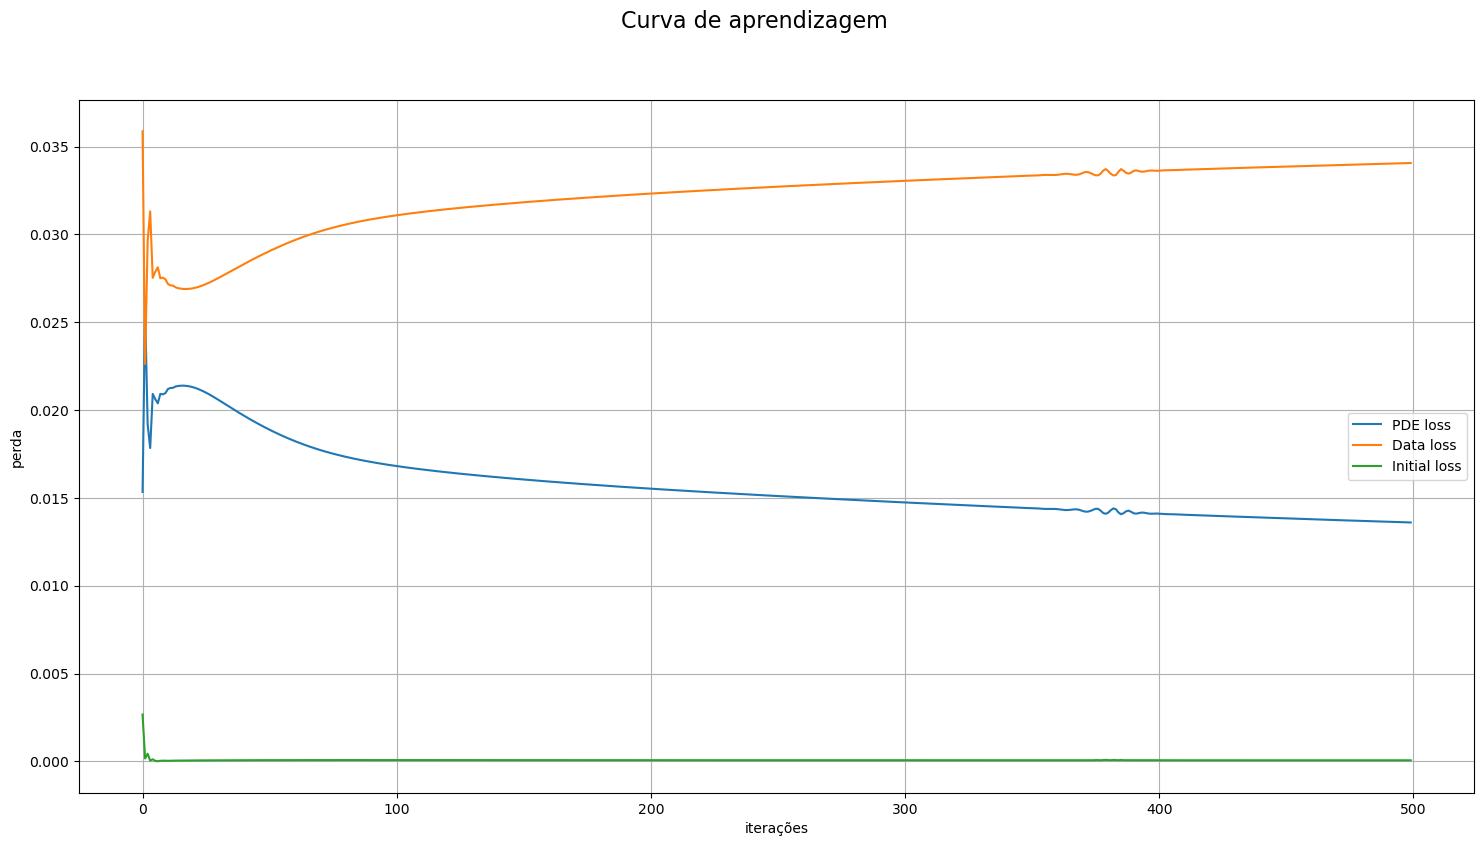

In [250]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle('Curva de aprendizagem', fontsize=16)


# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(range(len(C_pde_loss_it.cpu().numpy())),C_pde_loss_it.cpu().numpy(),label="PDE loss")
ax.plot(range(len(C_data_loss_it.cpu().numpy())),C_data_loss_it.cpu().numpy(),label="Data loss")
ax.plot(range(len(C_initial_loss_it.cpu().numpy())),C_initial_loss_it.cpu().numpy(),label="Initial loss")
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [251]:
with torch.no_grad():
    Cl,Cp = model(t).split(1,dim=1)

In [252]:
Cl = Cl.cpu().detach().numpy()
Cp = Cp.cpu().detach().numpy()


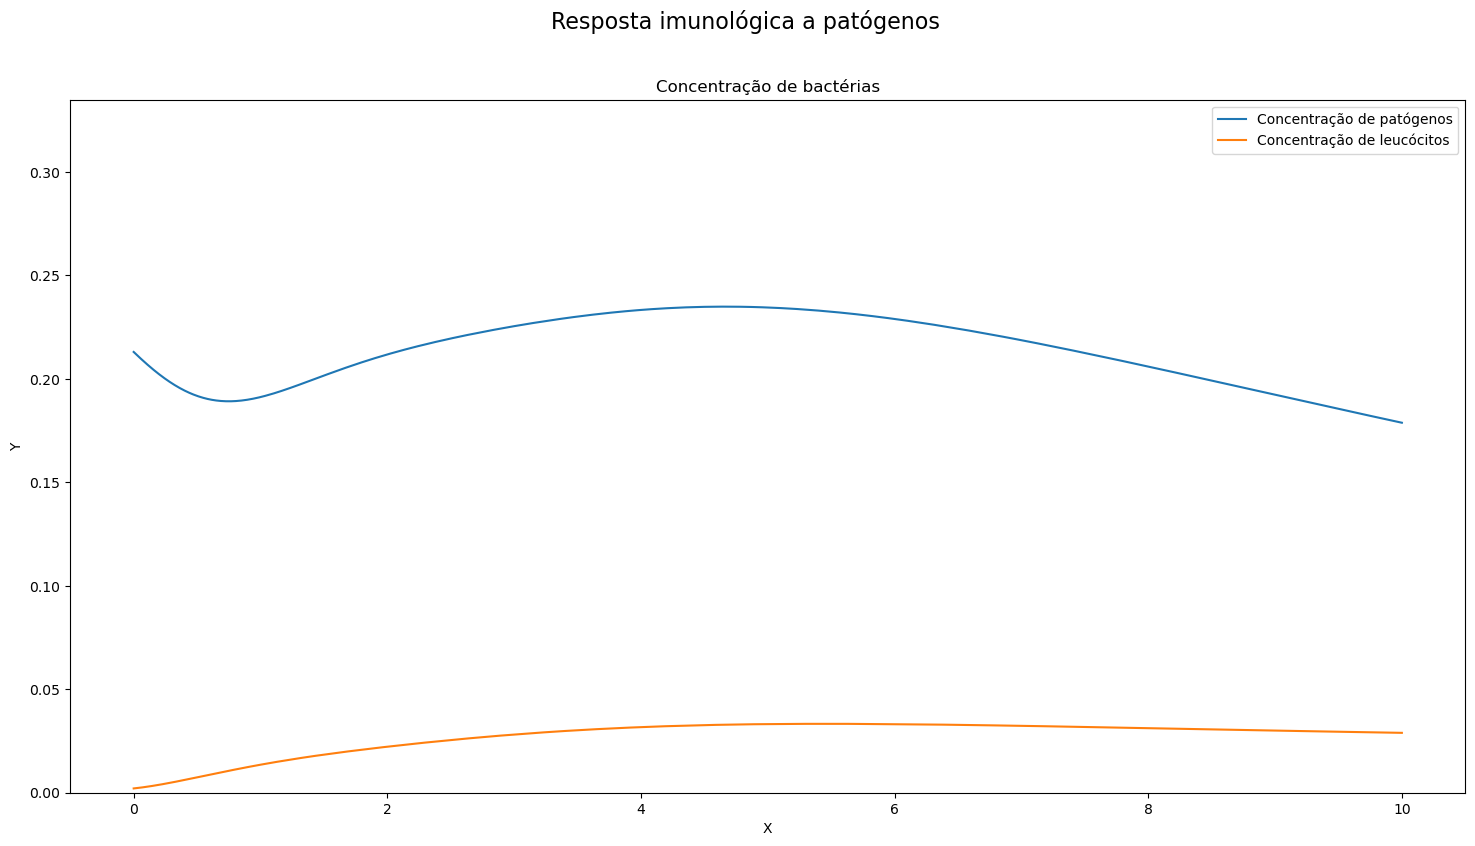

In [253]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)


vmin = 0
vmax = np.max([np.max(Cl), np.max(Cp)])

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.plot(t.cpu().detach().numpy(), Cp, label="Concentração de patógenos")
ax.plot(t.cpu().detach().numpy(), Cl, label="Concentração de leucócitos")
ax.set_title("Concentração de bactérias")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_ylim(vmin, vmax+0.1)
ax.legend()
plt.show()